In [1]:
!pip --quiet install gdown pycocotools

In [2]:
import numpy as np
import torch
import cv2 
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
import gdown
import random
from IPython.display import display
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import warnings
import gc
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### TACO 
the TACO dataset paper used Mask R-CNN architechture --> Pixel-wise segmentation (through classification)

In [ ]:
df_sample['img_file']

image-ID:  6


,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0,127.0,447.0,1322.0,403954.0
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0,457.0,1429.0,1519.0,1071259.5
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0,292.0,1006.0,672.0,99583.5


,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
16,6,1537,2049,batch_1/000055.jpg,11,Aerosol,Can,17,515.0,439.0,357.0,1125.0,238627.5


515 439 357 1125
(512, 512, 3)


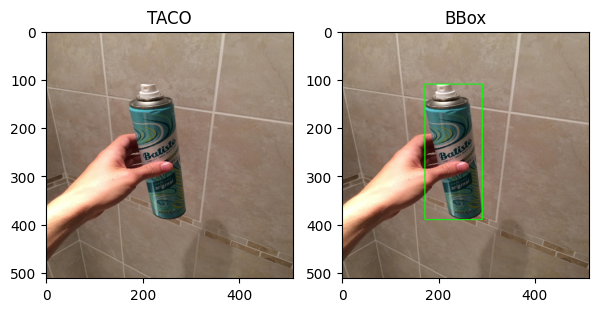

In [4]:
sample_dir = r"/kaggle/input/tacotrashdataset/data"
rn = random.randint(0, len(os.listdir(sample_dir)))
# rn = 6
print('image-ID: ', rn)

df_all_sample = pd.read_csv(r"/kaggle/input/tacotrashdataset/meta_df.csv")
display(df_all_sample.head(3))

df_sample = df_all_sample[df_all_sample['img_id'] == rn]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
annot_img = sample_img.copy()
x, y, w, h = int(df_sample['x'].tolist()[0]), int(df_sample['y'].tolist()[0]), int(df_sample['width'].tolist()[0]), int(df_sample['height'].tolist()[0])
print(x, y, w, h)
cv2.rectangle(annot_img, (x, y), (x + w, y + h), (0, 255, 0), 5)

annot_img = cv2.resize(annot_img, (512, 512))
sample_img = cv2.resize(sample_img, (512, 512))

print(sample_img.shape)

fig, axs = plt.subplots(1, 2 ,figsize = (7, 7))

axs[0].imshow(sample_img)
axs[0].set_title('TACO')

axs[1].imshow(annot_img)
axs[1].set_title('BBox')

plt.show()

In [ ]:
from pycocotools import mask as maskUtils
import json

image_id = random.randint(0, len(annot_json['images']))
# image_id = 7

df_sample = df_all_sample[df_all_sample['img_id'] == image_id]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
sample_img = cv2.resize(sample_img, (512, 512))

plt.imshow(sample_img)
plt.title("Image_ID: " + str(image_id))
plt.show()

with open('/kaggle/input/tacotrashdataset/data/annotations.json', 'rb') as f:
    annot = f.read()
f.close()

print('No. of images: ', len(annot_json['images']))
print()

img_width, img_height =  df_all_sample[df_all_sample['img_id'] == image_id]['img_width'].tolist()[0], df_all_sample[df_all_sample['img_id'] == image_id]['img_height'].tolist()[0]
print('image_id: ', image_id, ', image_w: ', img_width, ', image_h: ', img_height)
print()
print(annot_json.keys())
print()
annot_json = json.loads(annot)
selected_annot = [d for d in annot_json['annotations'] if d['image_id'] == image_id]

print(selected_annot)
print()


def seg_visx(sample_img, annot_list, image_id, height, width, alpha = 0.55, beta = 0.45):
     
    mask_list = []
    
    for i, annot in enumerate(annot_list):
        
        segm = annot['segmentation']
        print('Image_ID: ', annot['image_id'])
        
        if isinstance(segm, list):
            
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)        
        elif isinstance(segm['counts'], list):
            
            rle = maskUtils.frPyObjects(segm, height, width)      
        else:
            
            rle = annot['segmentation']
            
        mask = maskUtils.decode(rle)
        mask = cv2.resize(mask, (512, 512))
#         color_mask = np.zeros_like(sample_img)
    
        if i == 0:      
            color_mask = np.zeros_like(sample_img)
            bin_mask = mask
            
        else:
            bin_mask[mask == 1] = 1
            
        color_mask[bin_mask == 1] = (0, 255, 0)  # Green color with alpha=100 (adjust as needed)
        mask_list.append(mask)
        
    color_mask_img = cv2.addWeighted(sample_img, alpha, color_mask, beta, 0)  # Blend with mask1
    
    return mask_list, bin_mask, color_mask_img

# height, width = 512, 512
_, bin_mask, color_mask_img = seg_visx(sample_img, selected_annot, image_id, img_height, img_width)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(bin_mask, cmap = 'gray')
axs[0].set_title('Seg-Mask')

axs[1].imshow(color_mask_img)
axs[1].set_title('Masked-Img')

plt.show()

### India-Specific | IndoSet
We aim to perform Binary Instance pixel-wise classification into Liftables (plastic Bag, Paper etc) and Removables (Gutka Stains, Pan Masala etc.) 

https://drive.google.com/file/d/1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV/view?usp=drive_link

In [33]:
india_data_path = r"/kaggle/input/data-india-v1/data.txt"
with open(india_data_path, 'r') as f:
    file_id = f.read()[3:].split('/')[-2]
    
print('File-ID: ', file_id)

ft = time.time()

ouput_path = "/kaggle/working/india-data.zip"

file_link = r"https://drive.google.com/uc?id=" + file_id
gdown.download(file_link, quiet=False, output = ouput_path)
!unzip -q "/kaggle/working/india-data.zip"

lt = time.time()
print('time-taken: ', (lt - ft) / 60, ' mins')

File-ID:  1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV


Downloading...
From (original): https://drive.google.com/uc?id=1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV
From (redirected): https://drive.google.com/uc?id=1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV&confirm=t&uuid=b50b36ae-db32-4379-bb09-dcc166cd9192
To: /kaggle/working/india-data.zip
100%|██████████| 1.30G/1.30G [00:17<00:00, 73.7MB/s]


time-taken:  0.512859567006429  mins


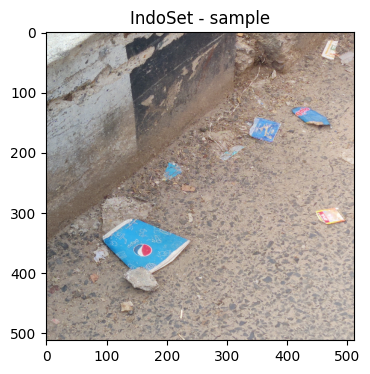

In [117]:
india_data_path = r"/kaggle/working/Dgen-VES"

def sample_indoset():
    rn = random.randint(0, len(os.listdir(india_data_path)))
    sample_img_path = os.path.join(india_data_path, os.listdir(india_data_path)[rn])
    sample_img_indo = cv2.imread(sample_img_path)
    sample_img_indo = cv2.cvtColor(sample_img_indo, cv2.COLOR_RGB2BGR)
    sample_img_indo = cv2.resize(sample_img_indo, (512, 512))
    return sample_img_indo

sample_img_indo = sample_indoset()
fig = plt.figure(figsize = (4, 4))
plt.imshow(sample_img_indo)
plt.title('IndoSet - sample')

plt.show()

----

### Segementation Module | Seg-VSE

---

In [ ]:
import importlib
importlib.reload(dmp)

In [ ]:
import data_mask_pipeline as dmp

num_samples = 1400

ft = time.time()
dsp = dmp.data_segment_pipeline(num_samples = num_samples)
samples, masks = dsp.seg_visx()
lt = time.time()

# ft = time.time()
# dsp = dmp.data_segment_pipeline(num_samples = num_samples)
# samples, masks, sample_mask = dsp.seg_visx()
# lt = time.time()

print('time-taken for data-loading: ', (lt - ft) / 60, 'mins')
print('Samples-Size: ', samples.shape, 'Mask-Size: ', masks.shape)
print()

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples)

axs[0].imshow(samples[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

time-taken for data-loading:  4.941125357151032 mins
Samples-Size:  (1400, 512, 512, 3) Mask-Size:  (1400, 512, 512)



Hugginface-Instance Prediction

In [ ]:
!pip -q install -U transformers accelerate

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import sys

# load Mask2Former fine-tuned on COCO panoptic segmentation

# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-instance")

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")


# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.fromarray(samples[rn])

# print(type(image), image.size)
# plt.imshow(image)
# plt.show()

# sys.exit()

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(image)
axs[0].set_title('Image')

axs[1].imshow(predicted_panoptic_map)
axs[1].set_title('Panoptic Map')

plt.show()

#### Data-Augmentation

In [ ]:
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        return default

def data_aug_pipeline(samples, masks, n_aug = 5):
    
    samples_aug, masks_aug = [], []
    
    for sample_image, sample_mask in zip(samples, masks):
    
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
            iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
            iaa.Fliplr(0.5),
            iaa.Add((-20, 20),name="Add"),
            iaa.Multiply((0.8, 1.2), name="Multiply"),
            iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
        ], random_order=True)

        hooks_masks = ia.HooksImages(activator=activator_masks)

        for i in range(n_aug):

            seq_det = seq.to_deterministic()
            image_augmented = seq_det.augment_image(sample_image)
            mask_augmented = seq_det.augment_image(sample_mask.astype(np.uint8), hooks=hooks_masks)

            samples_aug.append(image_augmented)
            masks_aug.append(mask_augmented)
    
    return np.array(samples_aug), np.array(masks_aug)

ft = time.time()
aug_samples, aug_masks = data_aug_pipeline(samples, masks)
lt = time.time()

print('time-taken for data-augmentation: ', (lt - ft)/60, ' mins')

samples_all = np.concatenate((samples, aug_samples))
masks_all = np.concatenate((masks, aug_masks))

shuffle_order = np.random.permutation(len(samples_all))

samples_all, masks_all = samples_all[shuffle_order], masks_all[shuffle_order]

print(aug_samples.shape, samples_all.shape, aug_masks.shape, masks_all.shape)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples)

axs[0].imshow(samples_all[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks_all[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

del samples
del masks
del aug_samples
del aug_masks

gc.collect()

time-taken for data-augmentation:  2.141987673441569  mins
(7000, 512, 512, 3) (8400, 512, 512, 3) (7000, 512, 512) (8400, 512, 512)


### Masked-Segmentation | UNET
BBox Anchoring is needed

In [5]:
!pip -q install torchsummary

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

class SegmentationModel(nn.Module):
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.entry_block = nn.Sequential(
            nn.Linear(in_features = img_size[1], out_features = img_size[1]),
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        ## More Convolution + Lower-Space Proj. | Custom Module Addition
        self.downsample_blocks = nn.ModuleList([
            EncoderBlock(32, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512),
            EncoderBlock(512, 1024)
        ])
        
        self.upsample_blocks = nn.ModuleList([
            
            DecoderBlock(1024, 512),
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64),
            DecoderBlock(64, 32)
        ])
        
        self.final_conv = nn.Conv2d(in_channels = 32, out_channels = num_classes, kernel_size = 3, padding = 1)
        self.final_trans_conv = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):
        
        x = self.entry_block(x)
        residuals = []
        for block in self.downsample_blocks:
            x, residual = block(x)
            residuals.append(residual)
            
        for block, residual in zip(self.upsample_blocks, reversed(residuals)):
            x = block(x, residual)
        x = self.final_trans_conv(x)
        x = self.final_conv(x)
        return x
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
        )
        self.residual_conv = nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 1, stride = 2)
    
    def forward(self, x):
        residual = self.residual_conv(x)
        x = self.block(x)
        x = x + residual
        return x, residual
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True),
        )
        self.residual_conv = nn.ConvTranspose2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 1)
    
    def forward(self, x, residual):
        residual = nn.functional.interpolate(residual, scale_factor = 2, mode = 'nearest')
        residual = self.residual_conv(residual)
        x = self.block(x)
        x = x + residual
        return x
    
img_size = (3, 512, 512)
num_classes = 2
model = SegmentationModel(img_size, num_classes).to(device)

# print(model)
summary(model, input_size = img_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 3, 512, 512]         262,656
            Conv2d-2         [-1, 32, 256, 256]             896
       BatchNorm2d-3         [-1, 32, 256, 256]              64
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           2,112
            Conv2d-6         [-1, 64, 256, 256]          18,496
       BatchNorm2d-7         [-1, 64, 256, 256]             128
              ReLU-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
     EncoderBlock-10  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
           Conv2d-11          [-1, 128, 64, 64]           8,320
           Conv2d-12        [-1, 128, 128, 128]          73,856
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

In [7]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegDataset(Dataset):
    def __init__(self, samples, masks):
        self.samples = samples
        self.masks = masks
        ## Wrong Normalization??
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        mask = self.masks[idx]
        sample = self.transform(sample).float() 
        
        mask = torch.from_numpy(mask)
        mask = torch.nn.functional.one_hot(mask.long(), num_classes=num_classes)
        
        return sample, mask

train_num, test_num = 0.85, 0.15 
train_samples, train_masks = samples_all[:int(train_num * len(samples_all))], masks_all[:int(train_num * len(samples_all))]   
test_samples, test_masks = samples_all[int(train_num * len(samples_all)) + 1:], masks_all[int(train_num * len(samples_all)) + 1:]

train_dataset = SegDataset(train_samples, train_masks)
test_dataset = SegDataset(test_samples, test_masks)

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

In [33]:
# for sample, mask in train_dataloader:
#     print(sample[0][:5])
#     break

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 60
losses = []

ft = time.time()
for epoch in range(num_epoch):   
    for samples, masks in train_dataloader:
        
        optimizer.zero_grad()        
#         print(samples.dtype, masks.dtype, samples.shape, masks.shape)
        
        samples = samples.to(device)
        masks = masks.to(device)
        
        outputs = model(samples)
        outputs = outputs.permute(0, 2, 3, 1)
        loss = criterion(outputs, masks.float())
                    
        loss.backward()
        optimizer.step()
        
    print(f'Epoch - {epoch + 1}/{num_epoch} - Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
lt = time.time()
print('time-taken for training: ', (lt - ft) / 60, ' mins')

Epoch - 1/60 - Loss: 1571.5889
Epoch - 2/60 - Loss: 1584.3904
Epoch - 3/60 - Loss: 1592.4507
Epoch - 4/60 - Loss: 1590.2957
Epoch - 5/60 - Loss: 1567.7869
Epoch - 6/60 - Loss: 1576.7205
Epoch - 7/60 - Loss: 1589.5596
Epoch - 8/60 - Loss: 1593.5942
Epoch - 9/60 - Loss: 1569.0164
Epoch - 10/60 - Loss: 1582.3911
Epoch - 11/60 - Loss: 1574.4321
Epoch - 12/60 - Loss: 1583.6709
Epoch - 13/60 - Loss: 1577.9580
Epoch - 14/60 - Loss: 1562.3191
Epoch - 15/60 - Loss: 1559.9211
Epoch - 16/60 - Loss: 1580.1384
Epoch - 17/60 - Loss: 1583.8969
Epoch - 18/60 - Loss: 1576.4333
Epoch - 19/60 - Loss: 1583.4976
Epoch - 20/60 - Loss: 1550.5300
Epoch - 21/60 - Loss: 1578.7861
Epoch - 22/60 - Loss: 1571.8362
Epoch - 23/60 - Loss: 1587.9788
Epoch - 24/60 - Loss: 1566.4045
Epoch - 25/60 - Loss: 1562.5831
Epoch - 26/60 - Loss: 1565.4357
Epoch - 27/60 - Loss: 1542.6388
Epoch - 28/60 - Loss: 1576.7935
Epoch - 29/60 - Loss: 1577.3694
Epoch - 30/60 - Loss: 1576.7189
Epoch - 31/60 - Loss: 1589.7903
Epoch - 32/60 - L

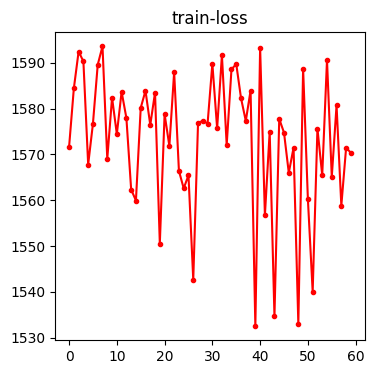

In [10]:
epoch_list = np.arange(0, num_epoch, 1)

fig = plt.figure(figsize = (4, 4))

plt.plot(epoch_list, losses, color = 'red', marker = '.')
plt.title('train-loss')
plt.show()

### Prediction
Done with an assummption of mean=0.5 and std=0.5 across all three channels

torch.Size([1, 3, 512, 512]) (512, 512)
(512, 512, 3) (512, 512) (512, 512)


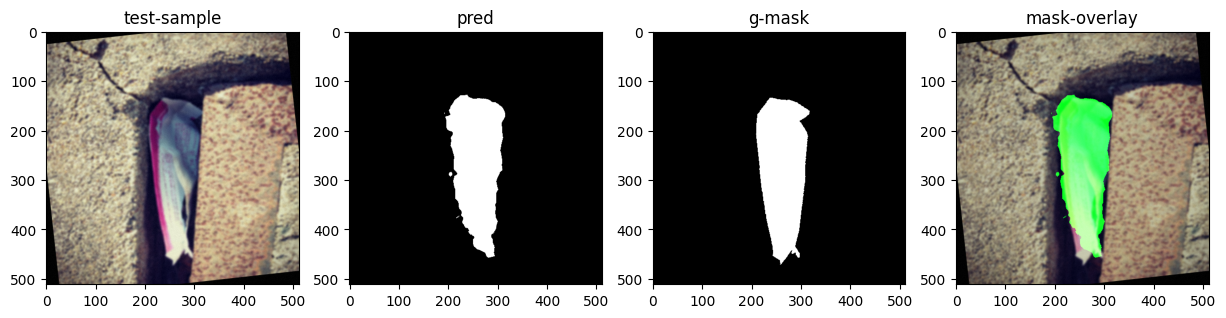

In [94]:
mean = 0.5
std = 0.5
alpha = 0.85
beta = 0.15

rn_test = random.randint(0, len(test_dataset))
one_test_sample, one_test_mask = test_dataset[rn_test] ## Normalized Data
one_test_sample = one_test_sample.unsqueeze(0)
one_test_mask = one_test_mask.argmax(-1).cpu().numpy()
print(one_test_sample.size(), one_test_mask.shape)

one_test_sample = one_test_sample.to(device)

model.eval()
pred = model(one_test_sample).permute(0, 2, 3, 1).argmax(-1).cpu().permute(1, 2, 0).numpy()
pred = np.squeeze(pred)
one_test_sample = one_test_sample.cpu()[0].permute(1, 2, 0).numpy()
one_test_sample = (one_test_sample * std) + mean

print(one_test_sample.shape, pred.shape, one_test_mask.shape)

color_mask = np.zeros_like(one_test_sample)
color_mask[pred == 1] = (0, 255, 0)
color_mask_img = cv2.addWeighted(one_test_sample, alpha, color_mask, beta, 0)

fig, axs = plt.subplots(1, 4, figsize = (15, 15))

axs[0].imshow(one_test_sample)
axs[0].set_title('test-sample')

axs[1].imshow(pred, cmap = 'gray')
axs[1].set_title('pred')

axs[2].imshow(one_test_mask, cmap = 'gray')
axs[2].set_title('g-mask')

axs[3].imshow(color_mask_img)
axs[3].set_title('mask-overlay')

plt.show()

#### IndoSet

(512, 512, 3) (512, 512) (512, 512, 3)


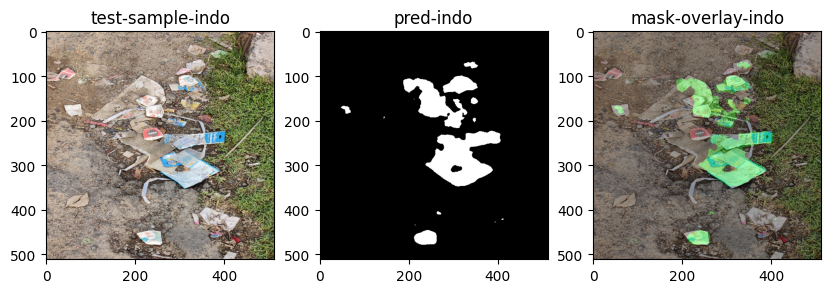

In [115]:
alpha = 0.7
beta = 1 - alpha
mean = 0.5
std = 0.5

sample_img_indo = sample_indoset()

sample_img_indo_input = sample_img_indo.copy()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

sample_img_indo_input = transform(sample_img_indo_input).unsqueeze(0)
sample_img_indo_input = sample_img_indo_input.to(device)
# print(sample_img_indo_input.size())

model.eval()
pred_indo = model(sample_img_indo_input.float()).permute(0, 2, 3, 1).argmax(-1).cpu().permute(1, 2, 0).numpy()
pred_indo = np.squeeze(pred_indo)

color_mask_indo = np.zeros_like(sample_img_indo)
color_mask_indo[pred_indo == 1] = (0, 255, 0)

color_mask_img_indo = cv2.addWeighted(sample_img_indo, alpha, color_mask_indo, beta, 0)

print(sample_img_indo.shape, pred_indo.shape, color_mask_img_indo.shape)

fig, axs = plt.subplots(1, 3, figsize = (10, 10))

axs[0].imshow(sample_img_indo)
axs[0].set_title('test-sample-indo')

axs[1].imshow(pred_indo, cmap = 'gray')
axs[1].set_title('pred-indo')

axs[2].imshow(color_mask_img_indo)
axs[2].set_title('mask-overlay-indo')

plt.show()

In [26]:
# model_state_dict = model.state_dict()
# torch.save(model_state_dict, 'u_net_ep-60-model_weights.pt')

model.load_state_dict(torch.load('u_net_ep-60-model_weights.pt'))

In [37]:
# one_test_sample, _ = test_dataset[rn_test]

# sample = one_test_sample.permute(1, 2, 0)

# mean = 0.5
# std = 0.5

# # Denormalize your data
# sample = (sample * std) + mean

# plt.imshow(sample)
# plt.title('test-sample')

# plt.show()

### DeepLabV3+ | Keras Implementaion

In [ ]:
def conv_block(
    block_input, 
    out_channel=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False
):
    in_channel = block_input.size()[1] 
    x = nn.Conv2d(in_channel = in_channel, out_channel = out_channel, kernel_size = kernel_size, dilation_rate = dilation_rate, padding=1, use_bia = use_bias)(block_input)
    x = nn.BatchNorm2d(out_channel)(x)
    x = nn.ReLU(inplace = True)(x)
    return x

def DitaledConv(dspp_input):
    dims = dspp_input.size()
    x = nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1)(dspp_input)
    x = conv_block(x, kernel_size = 1, use_bias = True)
    ## Pooled Output
    out_pool = nn.functional.interpolate(x, scale_factor = 2, mode = 'billinear')(x)
    
    ## Multi-Scale Convolution to capture diff range of features
    out_1 = conv_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = conv_block(dspp_input, kernel_size=3, dilation_rate=6)
    